In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

print("TF version = ", tf.VERSION)
print("Keras version = ",keras.__version__)
print("Keras backend = ", keras.backend.backend())
print("Default float type = ", keras.backend.floatx())
print("Image data structure = ", keras.backend.image_data_format())

def get_config_proto():
    config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    config.gpu_options.allow_growth = True
    return config

def set_session_config(config):
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
    
set_session_config(get_config_proto())

TF version =  1.11.0
Keras version =  2.1.6-tf
Keras backend =  tensorflow
Default float type =  float32
Image data structure =  channels_last


In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Turn ints to floats and Normalize values to <0,1>
x_train = x_train/255.0
x_test = x_test/255.0

In [3]:
print('x_train.shape', x_train.shape)
print('y_train.shape={} y_train[:5]={}'.format(y_train.shape, y_train[:5]))

x_train.shape (60000, 28, 28)
y_train.shape=(60000,) y_train[:5]=[5 0 4 1 9]


### Build encoder and decoder

Using variable scopes leads to nicer grouping in Tensorboard graph, but is unnecessary if you name Models.

In [4]:
LATENT_DIM = 16
IMG_SHAPE = (28, 28)
NOISE_RATIO = 0.1

def build_encoder():
    #with tf.variable_scope('encoder'):
    input_img = layers.Input(shape=IMG_SHAPE, name='encoder_input')
    noisy_img = layers.GaussianNoise(stddev=NOISE_RATIO, name='noisy_input')(input_img)
    flattened = layers.Flatten()(noisy_img)
    fc1 = layers.Dense(LATENT_DIM*4, activation=keras.activations.relu, name='fc_1')(flattened)
    fc2 = layers.Dense(LATENT_DIM*2, activation=keras.activations.relu, name='fc_2')(fc1)
    latent_repr = layers.Dense(LATENT_DIM, activation=keras.activations.relu, name='latent_repr')(fc2)
    return Model(input_img, latent_repr, name='encoder')

def build_decoder():
    #with tf.variable_scope('decoder'):
    latent_repr = layers.Input(shape=(LATENT_DIM, ), name='latent_repr_input')
    x = layers.Dense(LATENT_DIM*2, activation=keras.activations.relu, name='fc_1')(latent_repr)
    x = layers.Dense(LATENT_DIM*4, activation=keras.activations.relu, name='fc_2')(x)
    x = layers.Dense(np.prod(IMG_SHAPE), activation=keras.activations.relu, name='fc_3')(x)
    output_img = layers.Reshape(IMG_SHAPE)(x)
    return Model(latent_repr, output_img, name='decoder')

### Custom metrics and callback

 - Metrics are calculated and passed to callbacks as `logs` dictionary
 - Metrics not included in `stateful_metrics` will be averaged at epoch end by `BaseLogger`
 - name of the metric method = `avg_latent_repr` = new metric name

In [5]:
encoder = build_encoder()
decoder = build_decoder()

input_img = layers.Input(shape=IMG_SHAPE, name='input_img')
latent_repr = encoder(input_img)
output_img = decoder(latent_repr)

autoencoder = Model(input_img, output_img, name='autoencoder')

def avg_weight_metric():
    def avg_latent_repr(y_true, y_pred):
        return tf.reduce_mean(latent_repr)
        # This will throw: You must feed a value for placeholder tensor 'encoder_input' with dtype float and shape [?,28,28]
        #return tf.reduce_mean(autoencoder.get_layer('encoder').get_layer('latent_repr').output)
    return avg_latent_repr

class Custom_Callback(keras.callbacks.Callback):    
    def on_train_begin(self, logs={}):
        self._data = {'custom_metric':[]}

    def on_epoch_end(self, epoch, logs={}):
        # epoch indexed from 0
        # logs = dict of metrics and their values = will be in History object.
        print('epoch:', epoch)
        
        # Here it works = after the model is compiled I can access its layer outputs during training
        avg_output = tf.reduce_mean(self.model.get_layer('encoder').get_layer('latent_repr').output)
        self._data['custom_metric'].append(avg_output)
        return

    def get_data(self):
        return self._data
    
class CustomTBCallback(keras.callbacks.TensorBoard):
    def __init__(self, update_freq='epoch', **kw):
        super(CustomTBCallback, self).__init__(**kw)
        if update_freq == 'batch':
            self.update_freq = 1
        else:
            self.update_freq = update_freq
    
    def on_batch_end(self, batch, logs=None):
        if self.update_freq != 'epoch' and batch % self.update_freq == 0:
            super(CustomTBCallback, self).on_batch_end(batch, logs)
            #print('Updated TensorBoard on batch ', batch)

autoencoder.compile(loss=['mse'], metrics=['acc', avg_weight_metric()], optimizer=keras.optimizers.Adam(0.002))

In [6]:
latent_repr

<tf.Tensor 'encoder/latent_repr/Relu:0' shape=(?, 16) dtype=float32>

In [7]:
autoencoder.get_layer('encoder').get_layer('latent_repr').output

<tf.Tensor 'latent_repr/Relu:0' shape=(?, 16) dtype=float32>

In [8]:
encoder.get_layer('latent_repr').output

<tf.Tensor 'latent_repr/Relu:0' shape=(?, 16) dtype=float32>

In [9]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 16)                52848     
_________________________________________________________________
decoder (Model)              (None, 28, 28)            53616     
Total params: 106,464
Trainable params: 106,464
Non-trainable params: 0
_________________________________________________________________


In [10]:
TB_callback = CustomTBCallback(log_dir='./tf_logs', write_graph=True, update_freq=50)
metrics_cb = Custom_Callback()

history = autoencoder.fit(x_train, x_train,
              batch_size=128,
              epochs=10,
              verbose=2,
              validation_data=(x_test, x_test),
              callbacks=[metrics_cb, TB_callback]
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
Updated TensorBoard on batch  0
Updated TensorBoard on batch  50
Updated TensorBoard on batch  100
Updated TensorBoard on batch  150
Updated TensorBoard on batch  200
Updated TensorBoard on batch  250
Updated TensorBoard on batch  300
Updated TensorBoard on batch  350
Updated TensorBoard on batch  400
Updated TensorBoard on batch  450
epoch: 0
 - 4s - loss: 0.0425 - acc: 0.3808 - avg_latent_repr: 1.3739 - val_loss: 0.0310 - val_acc: 0.4461 - val_avg_latent_repr: 2.1766
Epoch 2/10
Updated TensorBoard on batch  0
Updated TensorBoard on batch  50
Updated TensorBoard on batch  100
Updated TensorBoard on batch  150
Updated TensorBoard on batch  200
Updated TensorBoard on batch  250
Updated TensorBoard on batch  300
Updated TensorBoard on batch  350
Updated TensorBoard on batch  400
Updated TensorBoard on batch  450
epoch: 1
 - 4s - loss: 0.0291 - acc: 0.4621 - avg_latent_repr: 2.4575 - val_loss: 0.0265 - val_acc: 0.4696 - val_avg_

In [11]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_avg_latent_repr', 'loss', 'acc', 'avg_latent_repr'])

In [12]:
num_pred = 16
predicted_imgs = autoencoder.predict(x_test[:num_pred]) 

In [13]:
# equivalent to predicted_imgs = autoencoder.predict(x_test[:num_pred]) 
latent_reprs = encoder.predict(x_test[:num_pred])
predicted_imgs = decoder.predict(latent_reprs)

In [14]:
latent_reprs[0]

array([4.9653115 , 3.2842224 , 2.3142393 , 0.        , 2.919654  ,
       0.        , 3.0169728 , 3.0380952 , 0.        , 2.1455538 ,
       0.18556616, 4.1848016 , 5.3739996 , 0.        , 3.9816232 ,
       0.55495006], dtype=float32)

Original Images


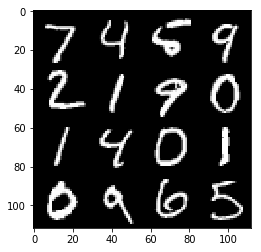

Noisy input image


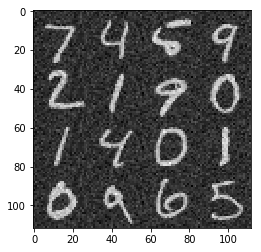

Reconstructed Images


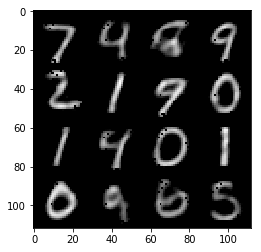

In [15]:
n = int(np.ceil(np.sqrt(num_pred)))
canvas_orig = []
canvas_recon = []
canvas_noisy = []
for i in range(n):
    # Display noisy input images
    canvas_noisy.append(np.concatenate((x_test[i*4:(i+1)*4] + np.random.normal(scale=NOISE_RATIO, size=IMG_SHAPE))))
    # Display original images
    canvas_orig.append(np.concatenate((x_test[i*4:(i+1)*4])))
    # Display reconstructed images
    canvas_recon.append(np.concatenate((predicted_imgs[i*4:(i+1)*4])))

print("Original Images")
plt.figure(figsize=(n, n))
plt.imshow(np.concatenate(canvas_orig, axis=1), origin="upper", cmap="gray")
plt.show()
    
print("Noisy input image")
plt.figure(figsize=(n, n))
plt.imshow(np.concatenate(canvas_noisy, axis=1), origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(np.concatenate(canvas_recon, axis=1), origin="upper", cmap="gray")
plt.show()